In [15]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from tqdm.autonotebook import tqdm, trange

## BASE CLASSES FOR MODELS

In [16]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return torch.sigmoid(self.linear2(x))

## AUTOENCODER MODELS

In [17]:
latent_dim = 8


class AE(torch.nn.Module):
  
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, state):
        h_enc = self.encoder(state)
        return self.decoder(h_enc)

class VAE(torch.nn.Module):

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(latent_dim, latent_dim)
        self._enc_log_sigma = torch.nn.Linear(latent_dim, latent_dim)

    def _sample_latent(self, h_enc):
        """
        Returns the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)

## TORCH LOSSES

In [18]:
def latent_loss_for_vae(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

## TORCH-COMPATIBLE DATA

In [19]:
import torchvision
from torchvision import transforms

In [20]:
input_dim = 28 * 28
batch_size = 32
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST('./', transform=transform, download=True)

dataloader = torch.utils.data.DataLoader(
        mnist_data, batch_size=batch_size, shuffle=True, num_workers=2 # On Colab you may ask for more than 2 workers maybe?
)

In [21]:
encoder1 = Encoder(input_dim, 100, latent_dim) # for these examples I set the hidden layer to size 100 but you can play with it
decoder1 = Decoder(latent_dim, 100, input_dim)

encoder2 = Encoder(input_dim, 100, latent_dim)
decoder2 = Decoder(latent_dim, 100, input_dim)

ae = AE(encoder1,decoder1)
vae = VAE(encoder2, decoder2)

## TORCH AE / VAE TRAINING

In [36]:
criterion = nn.BCELoss(reduction='sum') # Binary cross-entropy
optimizer = optim.Adam(ae.parameters(), lr=0.0001) # change to vae.parameters() for VAE version

l = None
for epoch in tqdm(range(30), desc="Epoch"):
    for i, data in enumerate(dataloader, 0):
        inputs, classes = data
        inputs, classes = Variable(inputs.resize_(batch_size, input_dim)), Variable(classes)
        optimizer.zero_grad()

        # Use one of these two for AE or VAE training

        # This is for VAE
        #dec = vae(inputs)
        #ll = latent_loss_for_vae(vae.z_mean, vae.z_sigma)
        #loss = criterion(dec, inputs) + ll

        # This is for "vanilla" AE
        decode = ae(inputs)
        loss = criterion(decode, inputs)

        loss.backward()
        optimizer.step()
        l = loss.item()
    # print(epoch, l)
    tqdm.write(f"\t\t{epoch=}, {l=}", end="")

Epoch:   3%|▎         | 1/30 [00:07<03:39,  7.59s/it]
epoch=0, l=3485.34765625
Epoch:   7%|▋         | 2/30 [00:15<03:32,  7.59s/it]
epoch=1, l=3451.40234375
Epoch:  10%|█         | 3/30 [00:22<03:25,  7.63s/it]
epoch=2, l=3560.97998046875
Epoch:  13%|█▎        | 4/30 [00:30<03:18,  7.63s/it]
epoch=3, l=3547.359375
Epoch:  17%|█▋        | 5/30 [00:38<03:12,  7.68s/it]
epoch=4, l=3680.173828125
Epoch:  20%|██        | 6/30 [00:46<03:04,  7.71s/it]
epoch=5, l=3832.96826171875
Epoch:  23%|██▎       | 7/30 [00:53<02:57,  7.72s/it]
epoch=6, l=3699.478271484375
Epoch:  27%|██▋       | 8/30 [01:02<02:53,  7.89s/it]
epoch=7, l=3693.30615234375
Epoch:  30%|███       | 9/30 [01:09<02:45,  7.88s/it]
epoch=8, l=3431.863525390625
Epoch:  33%|███▎      | 10/30 [01:17<02:36,  7.82s/it]
epoch=9, l=3355.361572265625
Epoch:  37%|███▋      | 11/30 [01:25<02:29,  7.85s/it]
epoch=10, l=3783.016357421875
Epoch:  40%|████      | 12/30 [01:33<02:19,  7.78s/it]
epoch=11, l=3914.804443359375
Epoch:  43%|████▎  

## ADAPT IMAGE DISPLAY TO TORCH

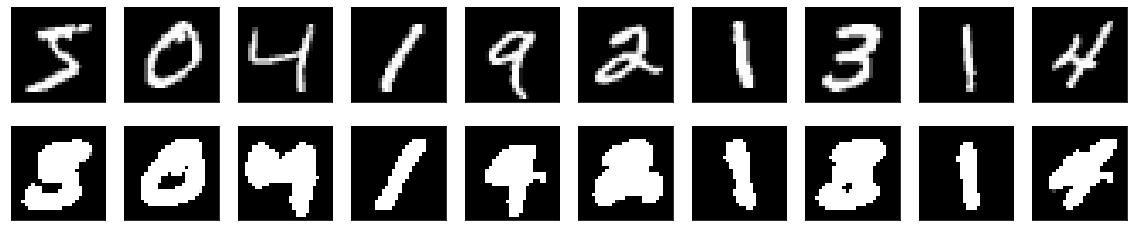

In [82]:
import matplotlib.pyplot as plt

# Choose model to plot
model = ae # or vae
X_test = dataloader.dataset.test_data

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    encoded_img = model.encoder(X_test[i].flatten().float())
    decoded_img = model.decoder(encoded_img).detach().numpy().reshape(28,28)
    plt.imshow(decoded_img, cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()